In [124]:
#Import packages
import os
import flopy
import numpy as np
import matplotlib.pyplot as plt
import flopy.utils.binaryfile as bf
import geopandas as gpd
from scipy import stats
from scipy.stats import norm
from scipy.signal import find_peaks
from scipy.stats.kde import gaussian_kde

In [29]:
## Set up directory referencing
# Package data
git_dir = os.path.dirname(os.path.dirname(os.getcwd()))
gwfm_dir = '\\'.join(str.split(git_dir,'\\')[0:3])+ '/Box/research_cosumnes/GWFlowModel'
print(git_dir, gwfm_dir)

C:\Users\arodri44\Documents\GitHub\CosumnesRiverRecharge C:\Users\arodri44/Box/research_cosumnes/GWFlowModel


In [30]:
loadpth = 'C:/wrdapp/GWFlowModel/Cosumnes/Cosumnes_simple'
model_ws = loadpth+'/WEL_RIV_RCH_tprogs_200layers/realization000'
m = flopy.modflow.Modflow.load('MF.nam', model_ws=model_ws, 
                                exe_name='MF2005', version='mf2005')

In [31]:
def plot_lines(lines):
    fig, ax = plt.subplots()
    for ln in lines:
        plt.plot([ln[0][0], ln[1][0]], [ln[0][1], ln[1][1]], linewidth = 0.1)

In [32]:
##Grid Creation for Large Model
# Load model grid as geopandas object
grid_regional = gpd.read_file(gwfm_dir+'/DIS_data/grid/grid.shp')
# grid_p = gpd.read_file(gwfm_dir+'/DIS_data/44_7_grid/44_7_grid.shp')
grid_p = gpd.read_file(gwfm_dir+'/DIS_data/Inset_grid_44_7/44_7_grid.shp')

grid_p_temp = grid_p.copy()
grid_p_temp.geometry = grid_p_temp.buffer(-99.9999)
# grid_regional.geometry = grid_regional.buffer(-100)

grid_ref = gpd.sjoin(grid_p_temp, grid_regional.to_crs('epsg:3310'), how = 'left',predicate = 'within',
                     lsuffix='inset', rsuffix = 'regional')
# grid_ref = pd.DataFrame(grid_ref.loc[:,['row_inset','column_inset','row_regional','column_regional']])
# reset geometry from tiny polygon to rectangle
grid_ref.geometry = grid_p.geometry

grid_ref = grid_ref.rename({'row_inset':'row','column_inset':'column'},axis=1)

<AxesSubplot:>

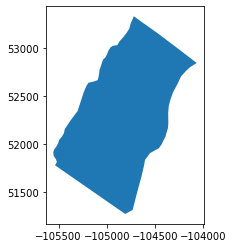

In [40]:
##TMosher Model Load
Rooney = gpd.read_file('C:/Users/arodri44/Box/research_cosumnes/Maps_GIS_and_GEP_files/GIS/OHWD shapefiles/OHWD recharge project files/Kautz Property2.shp')
Rooney_3310 = Rooney.to_crs('epsg:3310')
Rooney_3310.plot()

In [34]:
for n in np.arange(0,100).astype(str):
    model = 'C:/wrdapp/GWFlowModel/Cosumnes/Cosumnes_simple/WEL_RIV_RCH_tprogs_200layers/realization'+ n.zfill(3)+'/'
    hdobj = flopy.utils.HeadFile(model + '/MF.hds')
    head = hdobj.get_data(kstpkper = (0,0))
    head.shape
    A = head[100,:,:]
    A_new = np.reshape(A,(6300,1))
    grid_ref["Head"+n] = A_new


C:\Users\arodri44\Anaconda3\envs\geosp\lib\site-packages\geopandas\geodataframe.py:1351: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  super().__setitem__(key, value)


In [35]:
grid_ref

,node_inset,row,column,geometry,index_regional,node_regional,row_regional,column_regional,Head0,Head1,...,Head90,Head91,Head92,Head93,Head94,Head95,Head96,Head97,Head98,Head99
0,1,1,1,"POLYGON ((-117894.000 48118.820, -117751.840 4...",1948,1949,9,109,3.358167,4.326944,...,2.888797,-0.354227,4.263999,3.136524,4.300263,2.905443,4.909603,4.150355,5.220532,5.056922
1,2,1,2,"POLYGON ((-117751.840 48259.499, -117609.680 4...",1949,1950,9,110,3.319201,4.327958,...,2.735746,-0.386513,4.250545,3.156069,4.223138,2.954506,4.893579,4.139055,5.235111,5.019070
2,3,1,3,"POLYGON ((-117609.680 48400.178, -117467.520 4...",1950,1951,9,111,3.170191,4.239012,...,2.682422,-0.529883,4.213191,3.130275,4.035303,2.946380,4.830924,4.081017,5.243057,4.899511
3,4,1,4,"POLYGON ((-117467.520 48540.857, -117325.360 4...",1951,1952,9,112,2.981164,4.139895,...,2.429812,-0.594009,4.126674,3.066502,3.648173,2.844801,4.697750,3.970296,5.211206,4.702776
4,5,1,5,"POLYGON ((-117325.360 48681.536, -117183.201 4...",1952,1953,9,113,2.972182,3.886921,...,2.261228,-0.630476,3.992196,3.104651,3.325032,2.853782,4.486557,3.855139,5.232008,4.432890
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6295,6296,60,101,"POLYGON ((-95377.953 53799.280, -95235.793 539...",17911,17912,78,202,41.495831,40.547516,...,40.704048,40.972961,41.448055,41.086021,41.218731,41.213543,40.937912,40.377155,41.015308,40.844090
6296,6297,60,102,"POLYGON ((-95235.793 53939.959, -95093.633 540...",18142,18143,79,203,41.657249,40.862991,...,40.991062,41.246902,41.599243,41.301731,41.419090,41.422050,41.249485,40.754265,41.272751,41.102863
6297,6298,60,103,"POLYGON ((-95093.633 54080.638, -94951.473 542...",18143,18144,79,204,41.770359,41.193562,...,41.318050,41.476292,41.724705,41.500725,41.598320,41.584610,41.515270,41.467285,41.532665,41.368496
6298,6299,60,104,"POLYGON ((-94951.473 54221.317, -94809.313 543...",18144,18145,79,205,41.885056,41.591484,...,41.651272,41.731205,41.862579,41.740406,41.793327,41.775372,41.758045,41.803223,41.792404,41.675388


<AxesSubplot:>

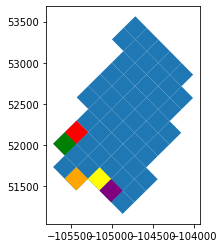

In [151]:
##Clip Data
#grid_ref = gpd.sjoin(grid_p_temp, grid_regional.to_crs('epsg:3310'), how = 'left',predicate = 'within',
                     #lsuffix='inset', rsuffix = 'regional')
grid_Rooney = gpd.sjoin(grid_ref, Rooney_3310)
#grid_teichert.plot()
fig = plt.figure()
ax = fig.add_subplot()
grid_Rooney.plot(ax = ax)
B1 = grid_Rooney.iloc[8:9,:]
B1.plot(ax = ax, color = 'green')
B2 = grid_Rooney.iloc[9:10,:]
B2.plot(ax = ax, color = 'red')
B3 = grid_Rooney.iloc[27:28,:]
B3.plot(ax = ax, color = 'orange')
B4 = grid_Rooney.iloc[37:38,:]
B4.plot(ax = ax, color = 'yellow')
B5 = grid_Rooney.iloc[45:46,:]
B5.plot(ax = ax, color = 'purple')

In [80]:
grid_Rooney

,node_inset,row,column,geometry,index_regional,node_regional,row_regional,column_regional,Head0,Head1,...,Head94,Head95,Head96,Head97,Head98,Head99,index_right,Id,Name,Area
2899,2900,28,65,"POLYGON ((-104997.435 53283.955, -104855.275 5...",9829,9830,43,170,29.575157,29.359070,...,29.383661,28.993441,29.861473,30.087578,29.605463,29.028021,0,0,Kautz Property,376
2900,2901,28,66,"POLYGON ((-104855.275 53424.634, -104713.116 5...",9830,9831,43,171,29.735575,29.492765,...,29.556787,29.139450,30.086000,30.279703,29.792788,29.217987,0,0,Kautz Property,376
3000,3001,29,61,"POLYGON ((-105425.396 52579.079, -105283.236 5...",9825,9826,43,166,28.924545,28.631504,...,28.632048,28.236698,29.018171,29.032017,28.827337,28.149954,0,0,Kautz Property,376
3001,3002,29,62,"POLYGON ((-105283.236 52719.758, -105141.076 5...",9826,9827,43,167,29.054880,28.796482,...,28.801619,28.405991,29.148451,29.208090,28.974537,28.277426,0,0,Kautz Property,376
3002,3003,29,63,"POLYGON ((-105141.076 52860.437, -104998.916 5...",9827,9828,43,168,29.178520,28.954300,...,28.963301,28.550493,29.284060,29.418348,29.120062,28.408701,0,0,Kautz Property,376
3003,3004,29,64,"POLYGON ((-104998.916 53001.116, -104856.756 5...",9828,9829,43,169,29.300611,29.103554,...,29.113535,28.702381,29.433247,29.628160,29.261436,28.606079,0,0,Kautz Property,376
3004,3005,29,65,"POLYGON ((-104856.756 53141.795, -104714.597 5...",10059,10060,44,170,29.421467,29.231453,...,29.268978,28.856310,29.600473,29.793116,29.400826,28.843124,0,0,Kautz Property,376
3005,3006,29,66,"POLYGON ((-104714.597 53282.474, -104572.437 5...",10060,10061,44,171,29.558064,29.361462,...,29.432148,29.007591,29.781441,29.956377,29.551771,29.025112,0,0,Kautz Property,376
3102,3103,30,58,"POLYGON ((-105711.197 52014.883, -105569.037 5...",10052,10053,44,163,28.406202,28.082272,...,28.065142,27.725998,28.498680,28.499857,28.329399,27.643147,0,0,Kautz Property,376
3103,3104,30,59,"POLYGON ((-105569.037 52155.562, -105426.877 5...",10053,10054,44,164,28.561758,28.243216,...,28.238701,27.849808,28.656336,28.657669,28.465776,27.785204,0,0,Kautz Property,376


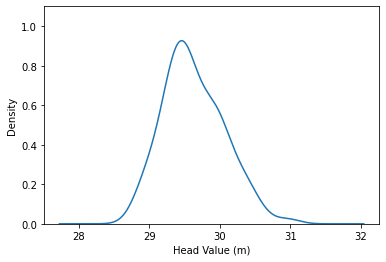

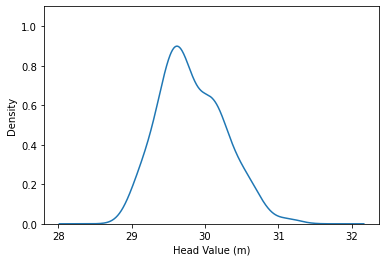

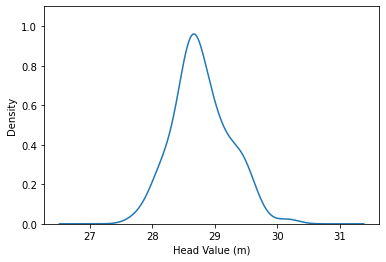

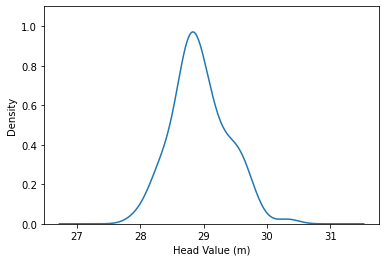

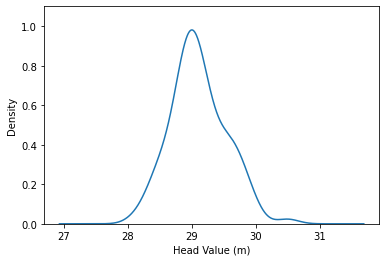

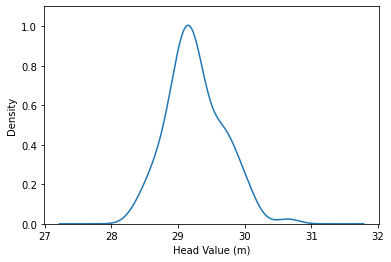

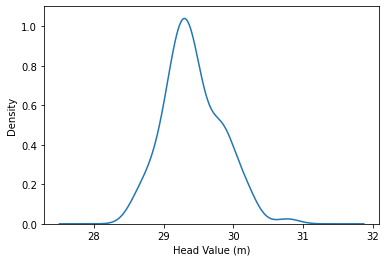

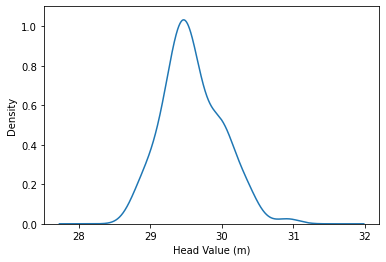

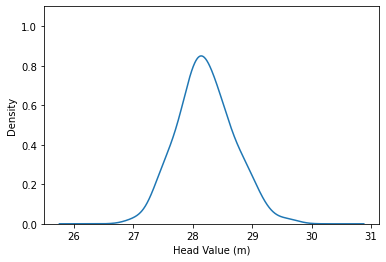

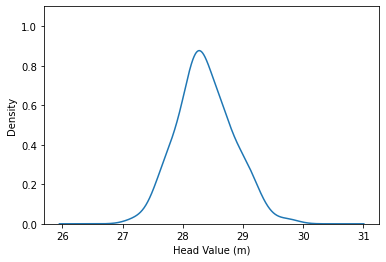

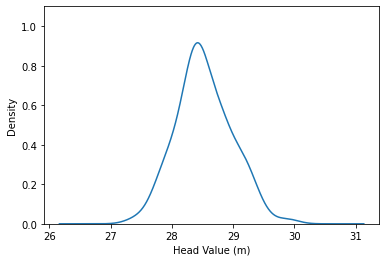

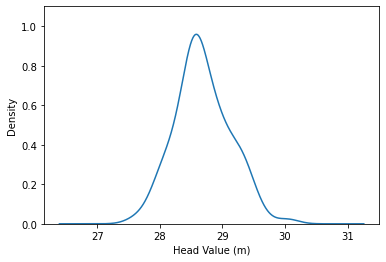

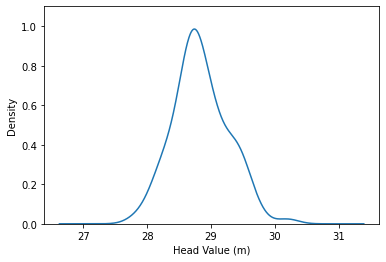

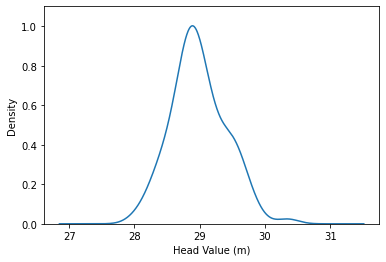

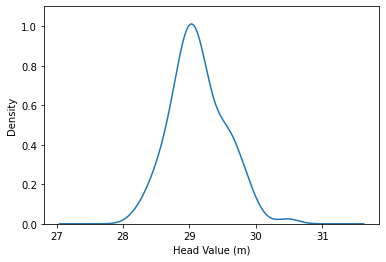

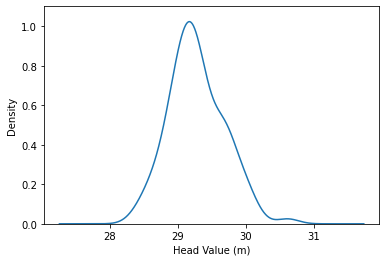

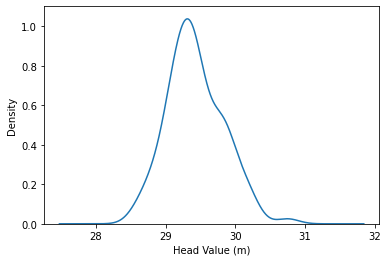

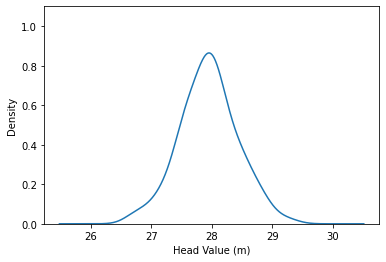

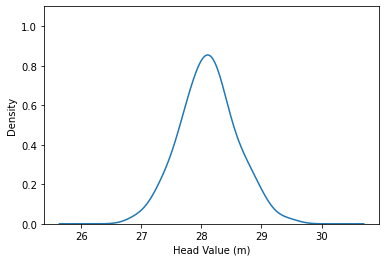

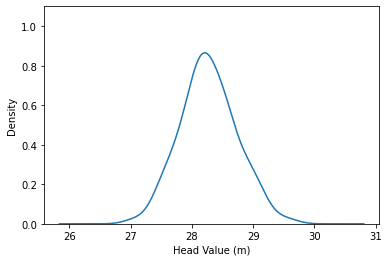

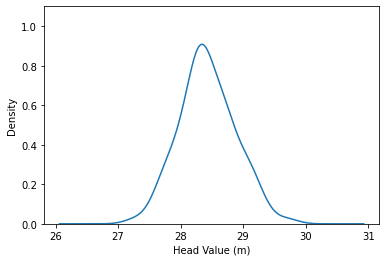

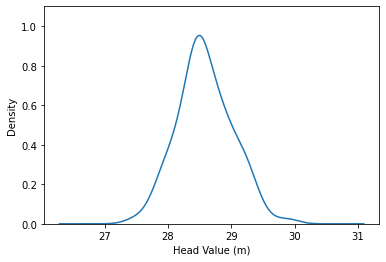

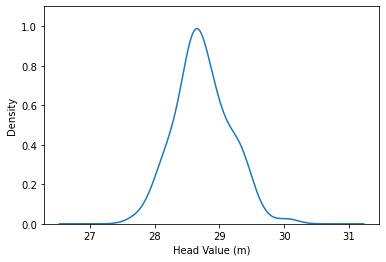

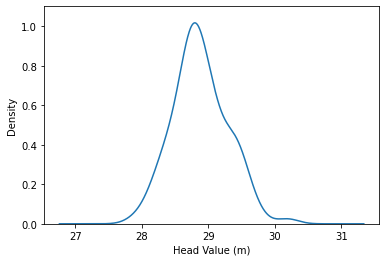

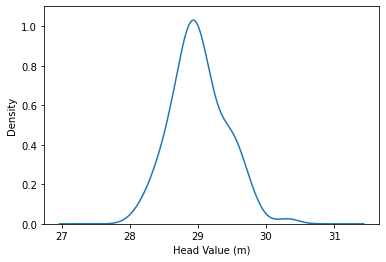

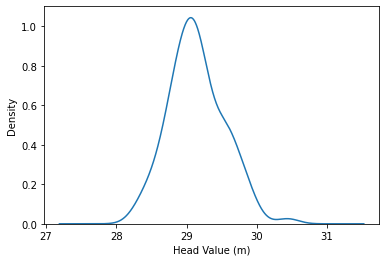

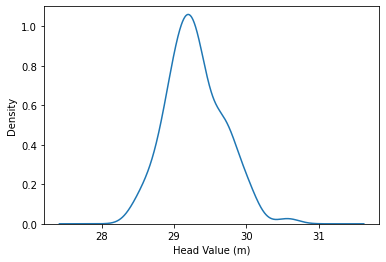

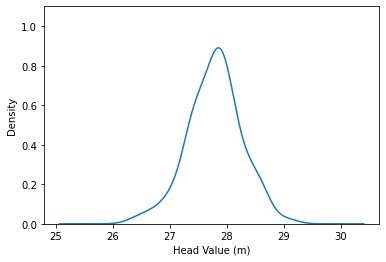

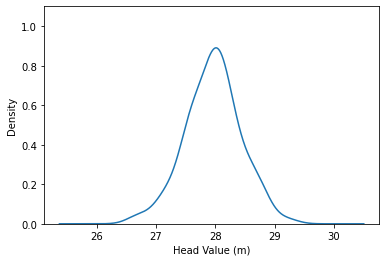

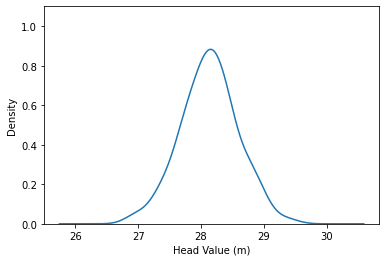

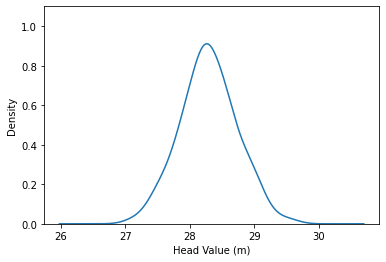

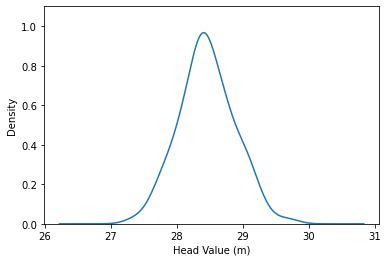

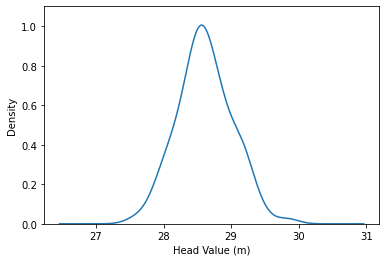

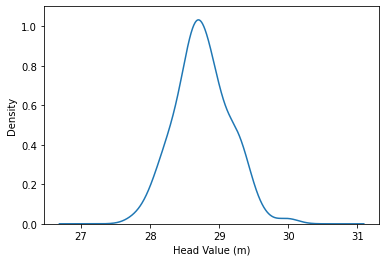

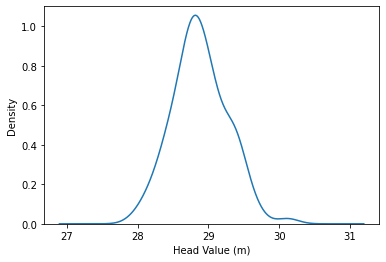

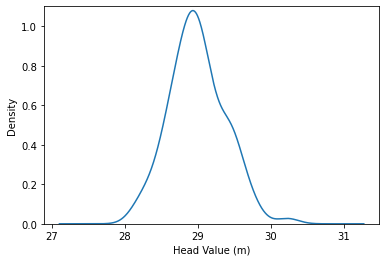

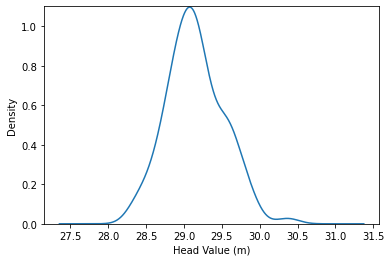

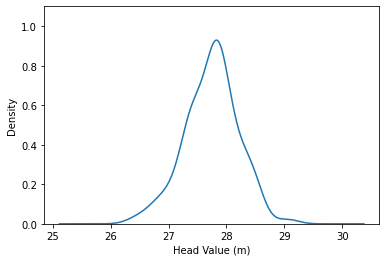

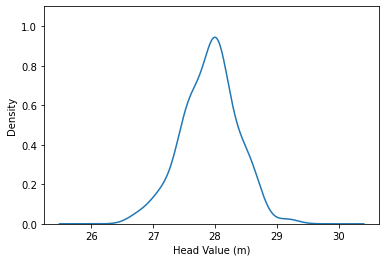

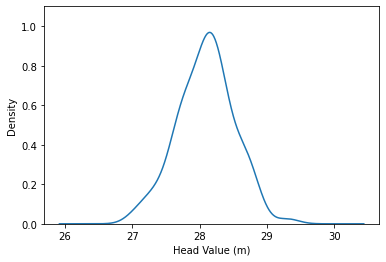

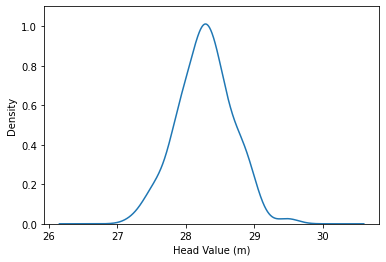

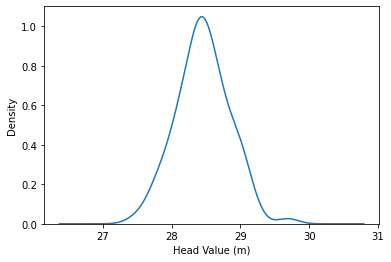

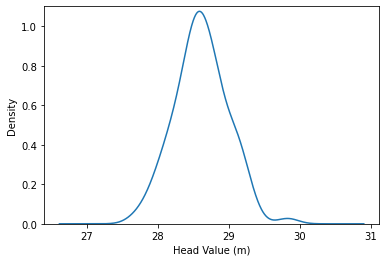

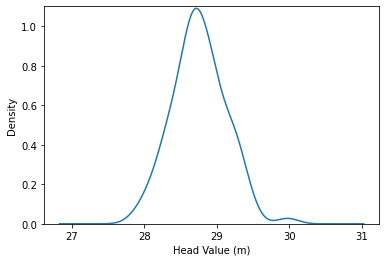

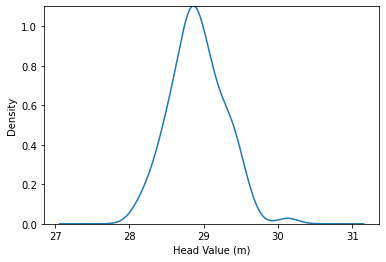

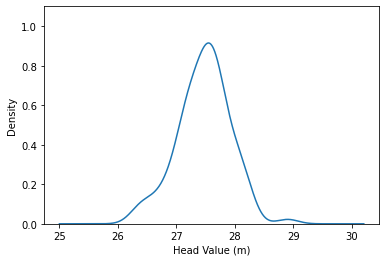

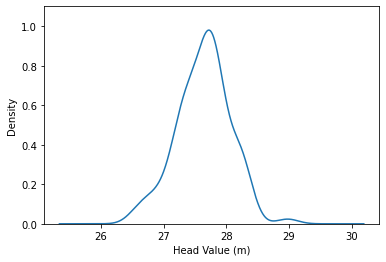

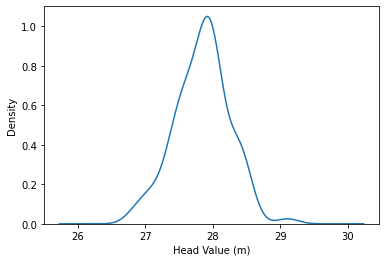

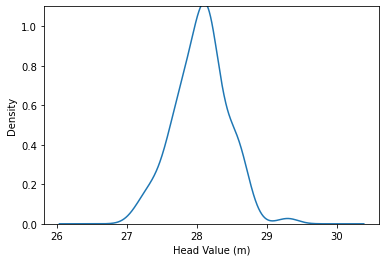

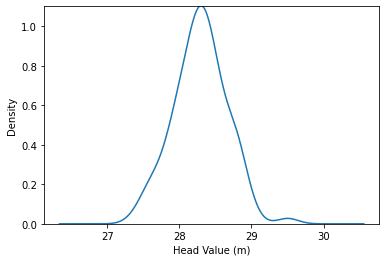

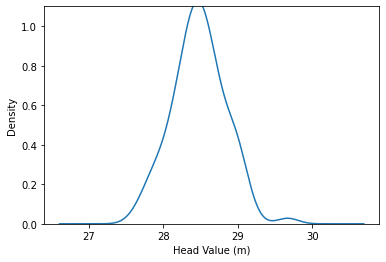

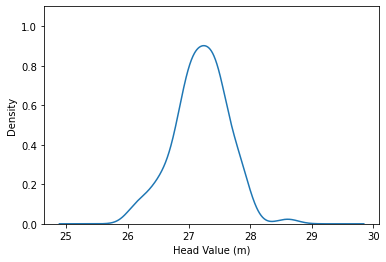

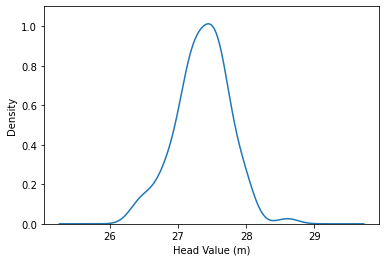

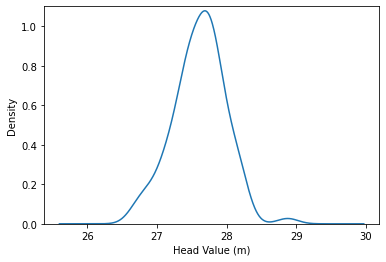

In [126]:
for r in np.arange(0,54):
    Plt = plt.figure()
    #ax = Plt.add_subplot(1,1,1)
    plt.ylim(0,1.1)
    X = grid_Rooney.iloc[r,8:108]
    # = stats.gaussian_kde(X)
    #norm.pdf(X)
    Plt = X.plot.kde()
    #Plt = PDF.plot()
    #AAA = find_peaks(PDF)
    #AAA
    plt.xlabel('Head Value (m)')
    

In [115]:
np.argwhere(np.isnan(X))

TypeError: ufunc 'isnan' not supported for the input types, and the inputs could not be safely coerced to any supported types according to the casting rule ''safe''

Text(0.5, 1.0, 'Rooney Highest Peaks')

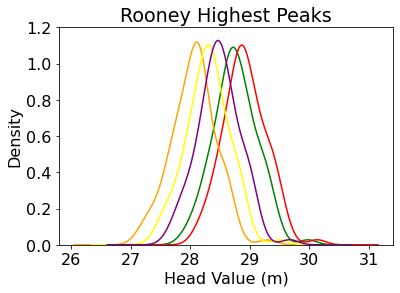

In [164]:
## Highest Peaks
plt.rcParams.update({'font.size': 16})
Plt = plt.figure()
ax = Plt.add_subplot(1,1,1)
plt.ylim(0,1.2)
X = grid_Rooney.iloc[43,8:108]
Plt = X.plot.kde(ax = ax, color = 'green')
X1 = grid_Rooney.iloc[44,8:108]
Plt = X1.plot.kde(ax = ax, color = 'red')
X2 = grid_Rooney.iloc[48,8:108]
Plt = X2.plot.kde(ax = ax, color = 'orange')
X3 = grid_Rooney.iloc[49,8:108]
Plt = X3.plot.kde(ax = ax, color = 'yellow')
X4 = grid_Rooney.iloc[50,8:108]
Plt = X4.plot.kde(ax = ax, color = 'purple')
    #Plt = PDF.plot()
    #AAA = find_peaks(PDF)
    #AAA
plt.xlabel('Head Value (m)')
plt.title('Rooney Highest Peaks')

Text(0.5, 1.0, 'Rooney Largest Spread')

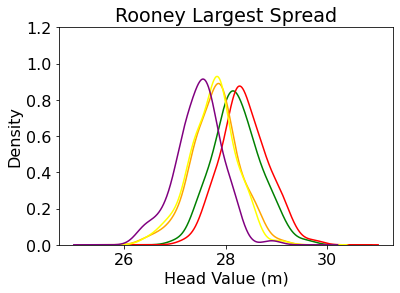

In [163]:
## Largest Spread
plt.rcParams.update({'font.size': 16})
Plt = plt.figure()
ax = Plt.add_subplot(1,1,1)
plt.ylim(0,1.2)
X1 = grid_Rooney.iloc[8,8:108]
Plt = X1.plot.kde(color = 'green')
X2 = grid_Rooney.iloc[9,8:108]
Plt = X2.plot.kde(color = 'red')
X6 = grid_Rooney.iloc[27,8:108]
Plt = X6.plot.kde(color = 'orange')
X8 = grid_Rooney.iloc[37,8:108]
Plt = X8.plot.kde(color = 'yellow')
X9 = grid_Rooney.iloc[45,8:108]
Plt = X9.plot.kde(color = 'purple')
    #Plt = PDF.plot()
    #AAA = find_peaks(PDF)
    #AAA
plt.xlabel('Head Value (m)')
plt.title('Rooney Largest Spread')

In [167]:
##Plot Head Data
def plot_head(hdobj, name):
    head = hdobj.get_data()
    levels_hmax = np.round(np.max(head[head!=1E+30]),-1)
#     levels_hmin = np.round(np.min(head[head!=-999.99]),-1)
    levels_hmin = np.round(np.min(head[head>=-200]),-1)
   # frf = cbb.get_data(text='FLOW RIGHT FACE')[0]
   # fff = cbb.get_data(text='FLOW FRONT FACE')[0]

    levels = np.arange(levels_hmin, levels_hmax, 2)

    fig = plt.figure(figsize=(30,20))

    ax = fig.add_subplot(1,1,1)
    ax.set_title(name+'Head Contours')
    mapview = flopy.plot.PlotMapView(model=m)
    quadmesh = mapview.plot_ibound()
#     line = mapview.plot_bc('RIV', plotAll=True)
    GHB = mapview.plot_bc("GHB", plotAll=True)
    CHD = mapview.plot_bc("CHD", plotAll=True)
    Teichert = gpd.read_file('C:/wrdapp/OHWD recharge project files/Kautz Property.shp')
    Teichert_3310 = Teichert.to_crs('epsg:3310')
    Teichert_3310.plot(ax = ax)
    Rooney = gpd.read_file('C:/Users/arodri44/Box/research_cosumnes/Maps_GIS_and_GEP_files/GIS/OHWD shapefiles/OHWD recharge project files/Kautz Property2.shp')
    Rooney_3310 = Rooney.to_crs('epsg:3310')
    Rooney_3310.plot(ax = ax)
    Cosumnes = gpd.read_file('C:/Users/arodri44/Box/research_cosumnes/GWFlowModel/SFR_data/NHD_MajorRivers/NHD_MajorRivers.shp')
    Cosumnes_3310 = Cosumnes.to_crs('epsg:3310')
    Cosumnes_3310.plot(ax = ax)

    contour_set = mapview.contour_array(head[5,:,:], masked_values=[-999.99, 1e+30], levels=levels)
#     quiver = mapview.plot_discharge(frf, fff, istep=10, jstep=10)  # no head array for volumetric discharge

    cb = plt.colorbar(contour_set, shrink = 0.5)
    cb.set_label('Head (m)')

    ax.ticklabel_format(style='plain')

    linecollection = mapview.plot_grid(linewidths = 0.3)
    plt.xlabel('Easting (m)')
    plt.ylabel('Northing (m)')
#     plt.savefig('Plots//'+name +'_head_contour.png', dpi = 600, bbox_inches='tight')

NameError: name 'mapview' is not defined

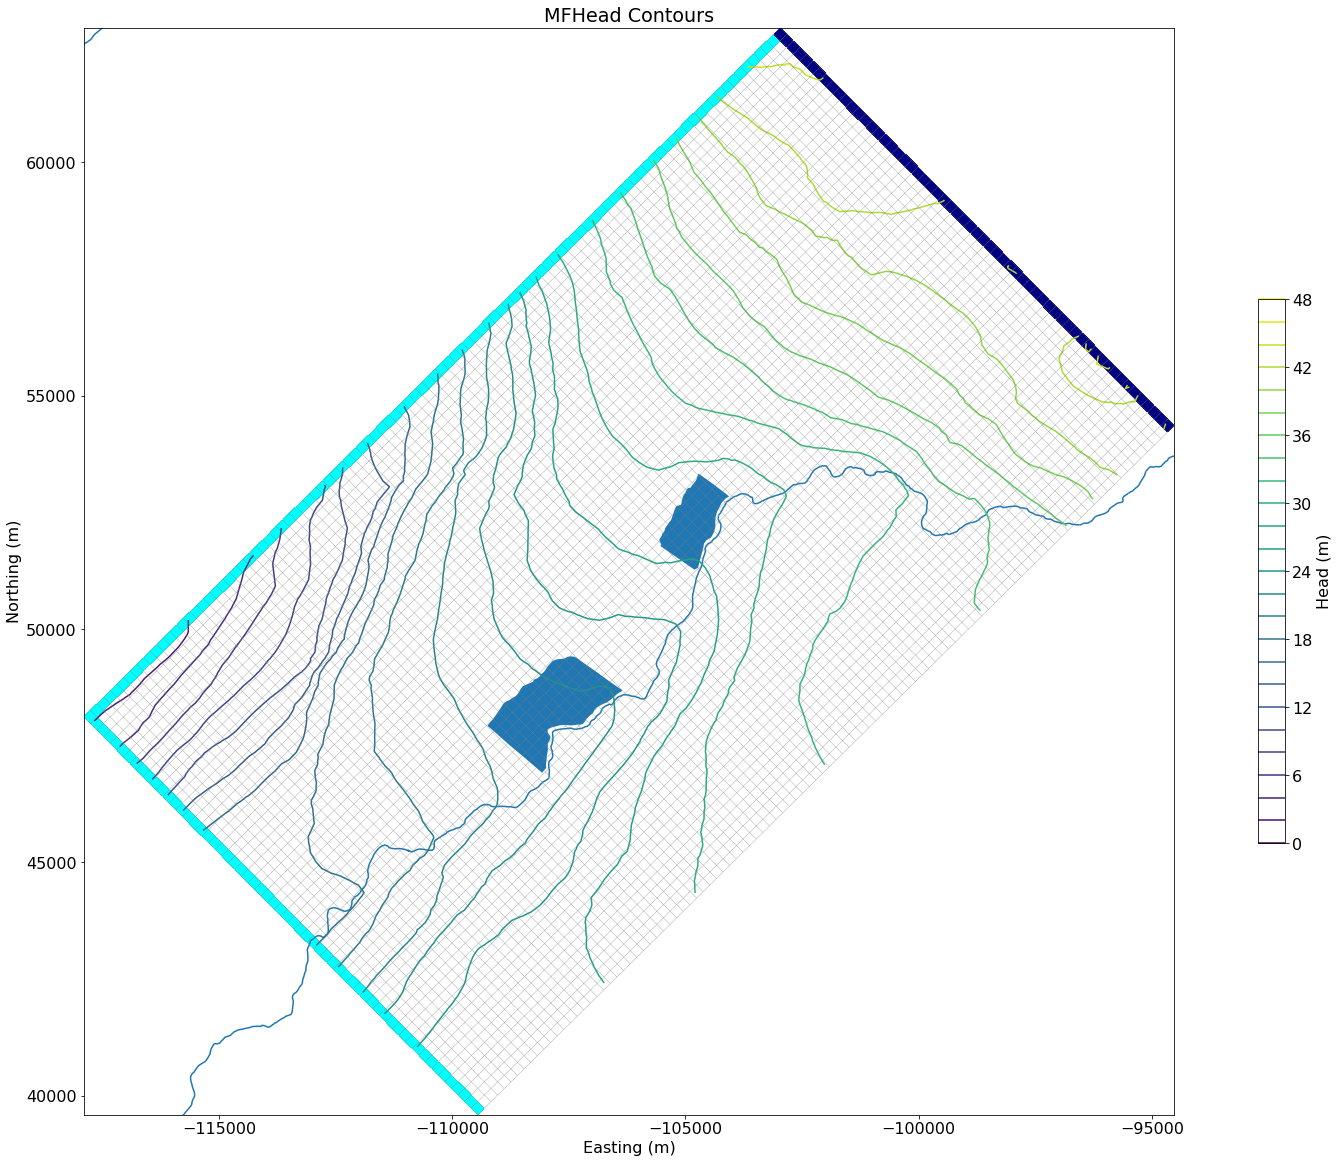

In [169]:
##Extract Heads to Array
hdobj = flopy.utils.HeadFile(model_ws + '/MF.hds')
#spd_stp = hdobj.get_kstpkper()
# for i in np.arange(0,len(spd_stp)):
plot_head(hdobj, 'MF')
#spd_stp
plt.savefig('Head_Contours')
Cosumnes = gpd.read_file('C:/Users/arodri44/Box/research_cosumnes/GWFlowModel/SFR_data/NHD_MajorRivers/NHD_MajorRivers.shp')
Cosumnes_3310 = Cosumnes.to_crs('epsg:3310')
GHB = mapview.plot_bc("GHB", plotAll=True)
CHD = mapview.plot_bc("CHD", plotAll=True)
plt.legend([Cosumnes_3310, GHB, CHD],['Cosumnes River', 'GHB', 'CHD'])


In [168]:
Cosumnes_3310

NameError: name 'Cosumnes_3310' is not defined

In [139]:
hdobj = flopy.utils.HeadFile(model_ws + '/MF.hds')
#hdobj.list_records()
rec = hdobj.get_data()
len(hdobj)

TypeError: object of type 'HeadFile' has no len()